In [1]:
import io
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [2]:
df = pd.read_csv('asset_returns.csv', names=[i for i in range(83)])
daily_returns = df.fillna(0)
daily_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,-0.005763,-0.026772,-0.087660,0.026042,-0.003650,-0.074595,-0.057377,-0.084338,-0.084821,0.081127,...,-0.049128,-0.094203,0.000000,-0.083417,0.109715,-0.025634,0.015899,-0.014392,0.042297,-0.010116
1,0.058059,0.113269,0.175373,0.096116,0.076657,0.120327,0.010870,0.102639,0.154634,0.130871,...,-0.029639,0.160000,-0.083081,-0.021158,-0.019817,0.030551,-0.021737,0.003431,0.004292,-0.065693
2,-0.037039,0.035610,-0.026984,-0.077318,-0.144086,-0.012513,-0.053763,-0.031031,-0.013519,-0.117281,...,-0.014870,-0.006897,-0.178512,0.004320,-0.009998,-0.049396,0.000881,-0.068494,-0.036105,0.003123
3,0.055546,-0.002807,0.093801,0.044626,0.089131,0.062302,0.011364,0.067736,0.018844,0.013110,...,0.052459,-0.055556,-0.051674,0.058668,-0.050943,0.096973,0.014222,0.087317,0.034290,0.004675
4,0.037787,0.035890,0.021626,0.163150,0.064524,0.053678,0.024719,0.035753,-0.121480,0.033673,...,0.046823,0.077206,0.036358,0.023387,-0.172145,0.128671,0.077061,0.014368,0.068786,0.062015


In [3]:
def optimal_weights(rets, target_return):
    mean_return = rets.mean().to_numpy().reshape(-1, 1)
    daily_cov = rets.cov().to_numpy()
    e = np.ones(len(mean_return)).reshape(-1, 1)
    result = []
    for r_p in target_return:
        
        top_row = np.hstack((daily_cov, -mean_return, -e))
        middle_row = np.hstack((-mean_return.T, np.zeros((1, 1)), np.zeros((1, 1))))
        bottom_row = np.hstack((-e.T, np.zeros((1, 1)), np.zeros((1, 1))))

        A = np.vstack((top_row, middle_row, bottom_row))
        b = np.vstack((np.zeros((len(mean_return), 1)), -r_p, -1))

        # Solve the linear system
        try:
            x = np.linalg.solve(A, b)
            result.append(x.flatten())
        except np.linalg.LinAlgError as err:
            print(f"Cannot solve linear system for target return {r_p}: {err}")
            continue

    results_df = pd.DataFrame(result, columns=[f"Asset {i+1}" for i in range(len(mean_return))] + ["Lambda", "Mu"])
    results_df.set_index(target_return, inplace=True)
    return results_df

### Actual average returns, backtesting:

$ \overline{r}^\top w $ - actual average returns

$ w^\top \Sigma w^\top $ - portfolio covariance 

where $w$ denote the optimal portfolio, $\overline{r}$ denote the average return over
the out-of-sample period, and $\Sigma$ denote the out of sample covariance matrix.


In [4]:
def backtesting(optimal_weights, OOS_rets, target_return):
    mean_return_OOS = OOS_rets.mean().to_numpy().reshape(-1, 1)
    daily_cov_OOS = OOS_rets.cov().to_numpy()
    arr = optimal_weights.to_numpy()
    res = []

    for index, row in enumerate(arr):
        weights = row[:-2]
        targ_ret = target_return[index]
        act_ave_return = (mean_return_OOS.T @ weights).item()
        pf_cov = weights.T @ daily_cov_OOS @ weights
        res.append([targ_ret, act_ave_return, pf_cov])
    
    return np.array(res)

# Main

In [5]:
target_return = np.linspace(0, 0.1, 21)

results_dict = {}
# N = len(range(0, daily_returns.shape[0]-100, 12))
for i in range(0, daily_returns.shape[0]-100, 12):
    index = int(i/12)
    start, mid, end = i, i+100, i +112
    daily_returns_IS = daily_returns.iloc[start:mid,:]
    daily_returns_OOS = daily_returns.iloc[mid:end]
    df_weights = optimal_weights(daily_returns_IS, target_return)
    df_act_returns = backtesting(df_weights, daily_returns_OOS, target_return)
    results_dict[index] = (pd.DataFrame(df_act_returns, columns=['target_return', 'Actual Average Return', 'Portfolio Covariance']).set_index('target_return'),\
                           df_weights)

In [6]:
results_dict[0][0]

,Actual Average Return,Portfolio Covariance
target_return,,
0.000,0.000454,0.000610
0.005,0.007940,0.001061
0.010,0.015426,0.001802
0.015,0.022912,0.002831
0.020,0.030398,0.004150
0.025,0.037885,0.005757
0.030,0.045371,0.007654
0.035,0.052857,0.009839
0.040,0.060343,0.012313


In [7]:
# Read the main CSV file and set the index
cpp_results = pd.read_csv('../cmake-build-debug/output_data.csv').set_index('ID')

# Function to convert space-separated values to semicolon-separated values
def convert_to_csv_format(data_str, x):
    values = data_str.replace(';', ' ').split()
    # Combine into semicolon-separated string
    csv_str = "\n".join(";".join(values[i:i+x]) for i in range(0, len(values), x))
    return csv_str

# Initialize an empty dictionary to store the parsed results
# Size 50: (df(21*2), df(21*85))
cpp_results_dict = {}

# Iterate through each row of the DataFrame
for index, (back_test_data, weights_data) in cpp_results.iterrows():
    try:
        # Parse the CSV data
        back_test_df = pd.read_csv(io.StringIO(convert_to_csv_format(back_test_data, 3)), header=None, sep=';').set_index(0)
        weights_df = pd.read_csv(io.StringIO(convert_to_csv_format(weights_data, 85)), header=None, sep=';')
        back_test_df.columns = ['Actual Average Return', 'Portfolio Covariance']
        weights_df.columns = [f"Asset {i+1}" for i in range(83)] + ["Lambda", "Mu"]
        
        cpp_results_dict[index] = (back_test_df, weights_df)
    except Exception as e:
        print(f"Error processing index {index}: {e}")


In [8]:
def plt1(x=cpp_results_dict):
    plot_data = {key: [] for key in np.linspace(0, 0.1, 21)}
    # Iterate through the dictionary and plot each series as a line
    for key, (df1, df2) in x.items():
        for i in df1.iterrows():
            plot_data[i[0]].append(i[1]['Actual Average Return'])

    plt.figure(figsize=(14, 7))
    for key, values in plot_data.items():
        plt.plot(range(len(values)), values, label=f'{key}', alpha=0.8)

    # Enhancing the plot for professional presentation
    plt.xlabel('Window Index', fontsize=12)
    plt.ylabel('Actual Average Return', fontsize=12)
    plt.title('Realised Rolling Window Average OOS Return for each Target', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Tight layout for better spacing
    plt.tight_layout()

    # plt.savefig('Realised_Rolling_Window_Average_OOS_Return.png')

    # Show the plot
    plt.show()

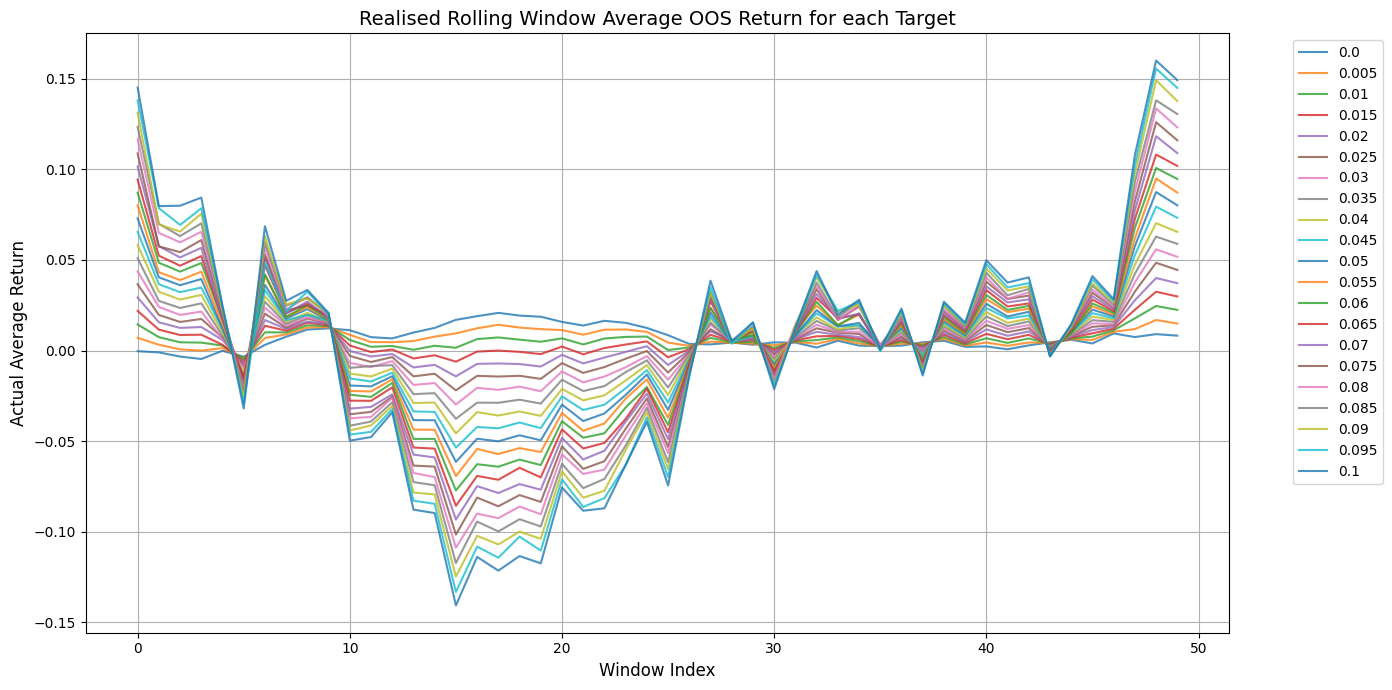

In [9]:
plt1()

In [10]:
# Function to plot the efficient frontier using Plotly
def plot_efficient_frontier(backtest_period, OOS, opt_weights_df, save_path=None):
    # Extract the corresponding out-of-sample daily returns data
    start_idx = backtest_period * 12 + 100
    end_idx = 100 + (backtest_period + 1) * 12
    OOS = OOS.iloc[start_idx:end_idx, :]
    opt_weights_df = opt_weights_df[backtest_period][1].iloc[:, :-2]

    # Prepare data for plotting
    expected_returns, cov_matrix = OOS.mean() * 252, OOS.cov() * 252
    
    # Create the figure
    fig = go.Figure()

    # Add scatter plot for optimal portfolios with color scale based on target returns
    target_returns = opt_weights_df.index / 200
    fig.add_trace(go.Scatter(
        x=[np.dot(weights, np.dot(cov_matrix, weights))**0.5 for idx, weights in opt_weights_df.iterrows()],
        y=[np.dot(weights, expected_returns) for idx, weights in opt_weights_df.iterrows()],
        mode='markers',
        marker=dict(
            size=12,
            color=target_returns,
            colorscale="RdBu",
            colorbar=dict(title="Target Return")
        ),
        name='Optimal Portfolios'
    ))

    # Update layout
    fig.update_layout(
        template='plotly_white',  # Generic formatting
        xaxis=dict(title='Annualised Risk (Volatility)'),
        yaxis=dict(title='Annualised Return'),
        title=f'Efficient Frontier with Optimal Portfolios (Backtest Period {backtest_period})',
        width=850,
        height=500
    )

    # Save the figure if a save path is provided
    if save_path:
        fig.write_image(save_path)

    fig.show()

In [11]:
# Define the backtest period
import kaleido
backtest_period = 9

# Plot the efficient frontier with all optimal portfolios
plot_efficient_frontier(backtest_period, daily_returns, cpp_results_dict, save_path='efficint_frontier.png')

In [12]:
# Function to plot cumulative returns
def plot_cumulative_returns(backtest_period, daily_returns, opt_weights_df, targ_ret, save_path=None):
    targ = {i/200: i for i in range(21)}

    # Extract the corresponding out-of-sample daily returns data
    start_idx = backtest_period * 12 + 100
    end_idx = 100 + (backtest_period + 1) * 12
    OOS = daily_returns.iloc[start_idx:end_idx, :]
    opt_weights = opt_weights_df[backtest_period][1].iloc[targ[targ_ret], :-2].values

    # Calculate cumulative returns for each asset
    cumulative_returns = (1 + OOS).cumprod()

    # Calculate cumulative returns for the optimized portfolio
    portfolio_returns = OOS.dot(opt_weights)
    cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

    # Create the figure
    fig = go.Figure()

    # Add traces for each asset
    for asset in cumulative_returns.columns:
        fig.add_trace(go.Scatter(
            x=cumulative_returns.index,
            y=cumulative_returns[asset],
            mode='lines',
            name=asset
        ))

    # Add trace for the optimized portfolio
    fig.add_trace(go.Scatter(
        x=cumulative_portfolio_returns.index,
        y=cumulative_portfolio_returns,
        mode='lines',
        name='Optimized Portfolio',
        line=dict(width=3, color='black')
    ))

    # Update layout
    fig.update_layout(
        template='plotly_white',  # Generic formatting
        xaxis=dict(title='Date'),
        yaxis=dict(title='Cumulative Returns'),
        title=f'Cumulative Returns of Optimized Portfolio vs. Assets (Backtest Period {backtest_period}, Target R {targ_ret})',
        width=850,
        height=500,
        showlegend=False
    )
    # Save the figure if a save path is provided
    if save_path:
        fig.write_image(save_path)

    fig.show()

plot_cumulative_returns(backtest_period, daily_returns, cpp_results_dict, targ_ret=0.04, save_path='cumulative_Rets.png')